## Benchmarking npmine

This notebook is dedicated to illustrate the benchmarking analysis of npmine's three sources of data: oscar, osra and gnfinder. The synthetic pdf was generated with the `generate_pdf` with the input present on _structures_1000_pdfs.json_ file.

In [21]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import AllChem
import numpy as np
import requests
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Define methods to compare structures recovered by oscar
def mol_similarity(smi1, smi2):
    try:
        ms1 = Chem.MolFromSmiles(smi1)
        ms2 = Chem.MolFromSmiles(smi2)
        #fps1 = Chem.RDKFingerprint(ms1)
        #fps2 = Chem.RDKFingerprint(ms2)
        fps1 = AllChem.GetMorganFingerprint(ms1, 2)
        fps2 = AllChem.GetMorganFingerprint(ms2, 2)
        #return DataStructs.FingerprintSimilarity(fps1, fps2)
        return DataStructs.TanimotoSimilarity(fps1, fps2)
    except:
        return None

def plot_panel(smi):
    ms = [Chem.MolFromSmiles(x) for x  in smi]
    img = Draw.MolsToGridImage(ms, molsPerRow=3, subImgSize=(200,200))
    return img

def score_molecules(ref_list, bench_list, idx):
    ln = len(ref_list)
    comp_list = ln*[[idx, '', '', 0]]
    for i in range(ln):
        fix_scr = 0
        x = ref_list[i]
        for y in bench_list:
            scr = mol_similarity(x, y)
            if scr==None:
                continue
            elif scr==1:
                comp_list[i] = [idx, x, y, scr]
                bench_list.remove(y)
                break
            else:
                if scr > fix_scr:
                    fix_scr = scr
                    comp_list[i] = [idx, x, y, scr]
    return comp_list

In [4]:
# Load the input for pdf simulation for comparison
with open('structures_1000_pdfs.json') as f:
    struct = json.load(f)

len(struct)

1000

In [5]:
# Load npmine results from synthetic pdfs
df = pd.read_csv('entities_img_dataframe.tsv', sep='\t')
df.head()

,doi,smiles,standardInChIKey,ExactMolWt,standardInChI,source
0,final-302.json,NaN,ALIFPGGMJDWMJH-UHFFFAOYSA-N,197.095297,InChI=1S/C12H11N3/c1-3-7-11(8-4-1)13-15-14-12-...,oscar
1,final-302.json,NaN,RDOXTESZEPMUJZ-UHFFFAOYSA-N,108.057515,"InChI=1S/C7H8O/c1-8-7-5-3-2-4-6-7/h2-6H,1H3",oscar
2,final-302.json,NaN,OMYXFRGZYJDEPI-UHFFFAOYSA-N,179.943598,InChI=1S/C4H5I/c1-2-4-5-3-1/h1-5H,oscar
3,final-302.json,NaN,VOQZCIGSIKSGAL-UHFFFAOYSA-N,228.047256,InChI=1S/C12H14Cl2/c1-7-9-3-4-10(9)12(6-14)8(2...,oscar
4,final-302.json,NaN,RYHBNJHYFVUHQT-UHFFFAOYSA-N,88.052429,InChI=1S/C4H8O2/c1-2-6-4-3-5-1/h1-4H2,oscar


In [6]:
# Ground truth's data structure
struct[0]

{'id': 0,
 'structures': ['[C@]123[C@@H]4N(C[C@@H]5[C@H]1CCN(C2)CCCC/C=C\\CCC4=C5)CCCC/C=C\\CC3',
  'Cc1cc2c(c(=O)n1CCc1ccc(c(c1)OC)OC)[C@H](C(=C(O2)N)C(=O)OC)c1cccnc1',
  'C(=O)([C@@](C(F)(F)F)(OC([C@@](C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)(F)F)F)[O-]',
  '[C@H]12[C@H]3N([C@@H](CC3)[C@H]3OC(=O)[C@H](C3)C)CCC[C@H]2O[C@@H]([C@H]1C)[C@H]1OC(=O)C(=C1)C',
  'CC1([C@@H]2[C@H]3CC[C@@H]([C@@]2(C[C@](C3)(O1)[C@H]1C[C@H](CC2(C1)CCCC2)Cc1ccc([nH+]c1)N)[NH3+])CO)C',
  'COC(=O)[C@@H]1CO[C@H]([C@H]2[C@@H]1CC=C2CO)O[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O'],
 'names': ['(2R,6S)-2-bromo-1,1,5,9-tetramethylspiro[5.5]undeca-4,9-diene',
  'Gold',
  'Limestone',
  '2-[(4aR)-9-(5-chloro-2-methoxyphenyl)-5,11-dioxo-2,4,4a,6-tetrahydro-1H-pyrazino[3,4-c][1,4]benzodiazepin-3-yl]-2-oxoacetamide',
  '[(2S)-2-hydroxy-3-[(2R,3R,4S,5R,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxypropyl] (4Z,7Z,10Z,13Z)-hexadeca-4,7,10,13-tetraenoate',
  'Dimethyl sulfoxide',
  'Dimethyl sulfide',
  '[(2E)-3,7-dimethylocta

In [7]:
# replace document id to match ground truth
df['doi'] = df['doi'].str.replace('\\D', '')

In [8]:
# select osra source for comparison
osra = df[df['source']=='osra']
osra.head()

,doi,smiles,standardInChIKey,ExactMolWt,standardInChI,source
20490,143,C**1CCCC1,NaN,71.086075,NaN,osra
20491,928,C[C@H]1C(=*)COC1(C)C,NaN,112.088815,NaN,osra
20492,928,COCCc1ccc(cc1)*,NaN,135.080990,NaN,osra
20493,928,[Hf]C*[C@]12CC[C]34(C5(C2[S+]C(C[C@@]26C1C1CC(...,NaN,0.000000,NaN,osra
20494,982,OC/C=C\1/[C@H](Oc2c1cc(/C=C/C=O)cc2OC)c1ccc2c(...,HSJDBQXWIAEJOE-OHLPVAAFSA-N,366.110338,NaN,osra


In [9]:
osra[osra['doi']=='0']

,doi,smiles,standardInChIKey,ExactMolWt,standardInChI,source
23598,0,C=*1CC2/C=C/C[C]34=CCC[C@]5([C@H](N1CCCC3)*)[C...,NaN,0.000000,NaN,osra
23599,0,*OC(=O)C1=C(N)Oc2c(C1)c(=O)n(c(c2)C)CCc1ccc(c(...,NaN,385.139961,NaN,osra
23600,0,**C(C(OC(C(F)(F)F)(C(=O)O)*#*)(F)F)(C(F)(F)F)O...,NaN,457.963532,NaN,osra
23601,0,CC1C2C(OC1C1C=C(C(=O)O1)C)CCCN1C2CCC1C1CC(C(=O...,QAAYWVNRGVTWRB-UHFFFAOYSA-N,389.220223,NaN,osra
23602,0,NC1=N*C=C(C=C1)C[C@@H]1CC(CC2(C1)CCCC2)[C@H]1C...,NaN,425.304227,NaN,osra
23603,0,C#[O][C@H]1[C@H](CO[C@@H]2OCC([C@@H]3[C@H]2C*(...,NaN,0.000000,NaN,osra


In [10]:
struct[0]['structures']

['[C@]123[C@@H]4N(C[C@@H]5[C@H]1CCN(C2)CCCC/C=C\\CCC4=C5)CCCC/C=C\\CC3',
 'Cc1cc2c(c(=O)n1CCc1ccc(c(c1)OC)OC)[C@H](C(=C(O2)N)C(=O)OC)c1cccnc1',
 'C(=O)([C@@](C(F)(F)F)(OC([C@@](C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)(F)F)F)[O-]',
 '[C@H]12[C@H]3N([C@@H](CC3)[C@H]3OC(=O)[C@H](C3)C)CCC[C@H]2O[C@@H]([C@H]1C)[C@H]1OC(=O)C(=C1)C',
 'CC1([C@@H]2[C@H]3CC[C@@H]([C@@]2(C[C@](C3)(O1)[C@H]1C[C@H](CC2(C1)CCCC2)Cc1ccc([nH+]c1)N)[NH3+])CO)C',
 'COC(=O)[C@@H]1CO[C@H]([C@H]2[C@@H]1CC=C2CO)O[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O']

In [11]:
# Example structure comparison
mol_similarity(struct[0]['structures'][0], osra[osra['doi']=='0'].iloc[0, 1])

RDKit ERROR: [16:33:44] Explicit valence for atom # 7 C, 5, is greater than permitted


In [12]:
comp_list = []

for i in range(1000):
    ref_list = struct[i]['structures']
    if not len(ref_list):
        continue
    bench_list = osra.loc[osra['doi']==str(i), 'smiles'].tolist()
    comp_list.extend(score_molecules(ref_list, bench_list, i))

RDKit ERROR: [16:33:49] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:33:49] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [16:33:49] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:33:49] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [16:33:49] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:33:49] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [16:33:49] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:33:49] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:33:49] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [16:33:49] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:33:49] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [16:33:49] Explicit valence for atom # 10

RDKit ERROR: [16:33:50] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom #

RDKit ERROR: [16:33:50] Can't kekulize mol.  Unkekulized atoms: 7 8 11 13 14
RDKit ERROR: 
RDKit ERROR: [16:33:50] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Can't kekulize mol.  Unkekulized atoms: 7 8 11 13 14
RDKit ERROR: 
RDKit ERROR: [16:33:50] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Can't kekulize mol.  Unkekulized atoms: 7 8 11 13 14
RDKit ERROR: 
RDKit ERROR: [16:33:50] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Can't kekulize mol.  Unkekulized atoms: 7 8 11 13 14
RDKit ERROR: 
RDKit ERROR: [16:33:50] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:33:50] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [16:33:50] Expli

RDKit ERROR: [16:33:51] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:33:51] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [16:33:51] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:51] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [16:33:51] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:33:51] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [16:33:51] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:51] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [16:33:51] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:33:51] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:51] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [16:33:51] Explicit valence for a

RDKit ERROR: [16:33:52] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom

RDKit ERROR: [16:33:52] Explicit valence for atom # 12 H, 4, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 27 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 12 H, 4, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 27 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [16:33:52] Explicit valence for

RDKit ERROR: [16:33:53] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for at

RDKit ERROR: [16:33:53] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 19 C, 5, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:33:53] SMILES Parse Error: syntax error while parsing: *O[C@@H]1CC(=O)C2[C@@]31[O](=C)=*([C@]13[C@@H](*C2[C@H]1*1(=C)CCC2(C1)CCCC2)C)$C
RDKit ERROR: [16:33:53] SMILES Parse Error: Failed parsing SMILES '*O[C@@H]1CC(=O)C2[C@@]31[O](=C)=*([C@]13[C@@H](*C2[C@H]1*1(=C)CCC2(C1)CCCC2)C)$C' for input: '*O[C@@H]1CC(=O)C2[C@@]31[O](=C)=*([C@]13[C@@H](*C2[C@H]1*1(=C)CCC2(C1)CCCC2)C)$C'
RDKit ERROR: [16:33:53] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 19 C, 5, is greater than permitted
RDKit ERROR: [16:33:53] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:33:53] SMILES Parse Error: syntax error while parsing: *O[C@@H]1CC(

RDKit ERROR: [16:33:54] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:33:54] SMILES Parse Error: syntax error while parsing: I$C*([C@@H]1CC=C(C(=O)C1)C)C
RDKit ERROR: [16:33:54] SMILES Parse Error: Failed parsing SMILES 'I$C*([C@@H]1CC=C(C(=O)C1)C)C' for input: 'I$C*([C@@H]1CC=C(C(=O)C1)C)C'
RDKit ERROR: [16:33:54] Explicit valence for atom # 23 C, 5, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:33:54] SMILES Parse Error: syntax error while parsing: I$C*([C@@H]1CC=C(C(=O)C1)C)C
RDKit ERROR: [16:33:54] SMILES Parse Error: Failed parsing SMILES 'I$C*([C@@H]1CC=C(C(=O)C1)C)C' for input: 'I$C*([C@@H]1CC=C(C(=O)C1)C)C'
RDKit ERROR: [16:33:54] Explicit valence for atom # 23 C, 5, is greater than permitted
RD

RDKit ERROR: [16:33:54] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 28 C, 5, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 28 C, 5, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 28 C, 5, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [16:33:54] Explicit valence for 

RDKit ERROR: [16:33:55] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 28 C, 5, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 28 C, 5, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for a

RDKit ERROR: [16:33:55] Explicit valence for atom # 24 N, 4, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 12 Li, 4, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 24 N, 4, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [16:33:55] Explicit valence for a

RDKit ERROR: [16:33:56] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:33:56] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:33:56] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:33:56] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:33:56] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:33:56] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:33:56] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:33:56] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:33:56] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:33:56] Explicit valence for atom # 35 N, 4, is greater than permitted
RDKit ERROR: [16:33:56] Explicit valence for atom # 27 H, 3, is greater than permitted
RDKit ERROR: [16:33:56] Explicit valence for at

RDKit ERROR: [16:33:57] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [16:33:57] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [16:33:57] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [16:33:57] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:33:57] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [16:33:57] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [16:33:57] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:33:57] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [16:33:57] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [16:33:57] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:33:57] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [16:33:57] Explicit valence for atom #

RDKit ERROR: [16:33:58] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom

RDKit ERROR: [16:33:58] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 10 H, 4, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 10 H, 4, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 10 H, 4, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 10 H, 4, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:33:58] Explicit valence fo

RDKit ERROR: [16:33:59] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:33:59] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [16:33:59] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [16:33:59] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [16:33:59] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:33:59] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [16:33:59] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [16:33:59] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [16:33:59] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:33:59] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [16:33:59] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [16:33:59] Explicit valence for a

RDKit ERROR: [16:34:00] SMILES Parse Error: syntax error while parsing: C$O[C@@H]1CO[C@@H]([C@H]1*)*C(SCC)SCC
RDKit ERROR: [16:34:00] SMILES Parse Error: Failed parsing SMILES 'C$O[C@@H]1CO[C@@H]([C@H]1*)*C(SCC)SCC' for input: 'C$O[C@@H]1CO[C@@H]([C@H]1*)*C(SCC)SCC'
RDKit ERROR: [16:34:00] SMILES Parse Error: syntax error while parsing: C$O[C@@H]1CO[C@@H]([C@H]1*)*C(SCC)SCC
RDKit ERROR: [16:34:00] SMILES Parse Error: Failed parsing SMILES 'C$O[C@@H]1CO[C@@H]([C@H]1*)*C(SCC)SCC' for input: 'C$O[C@@H]1CO[C@@H]([C@H]1*)*C(SCC)SCC'
RDKit ERROR: [16:34:00] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 39 C, 5, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 12 N, 6, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 39 C, 5, is greater than permitted
RDKit ERROR: [16:34:00] Explicit 

RDKit ERROR: [16:34:00] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 26 C, 6, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 26 C, 6, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 26 C, 6, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:00] Explicit valence for atom

RDKit ERROR: [16:34:01] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 10 C, 6, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 10 C, 6, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom

RDKit ERROR: [16:34:01] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 28 C, 5, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 18 N, 4, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 11 F, 2, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 28 C, 5, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for atom # 18 N, 4, is greater than permitted
RDKit ERROR: [16:34:01] Explicit valence for 

RDKit ERROR: [16:34:02] Explicit valence for atom # 15 O, 4, is greater than permitted
RDKit ERROR: [16:34:02] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [16:34:02] Explicit valence for atom # 15 O, 4, is greater than permitted
RDKit ERROR: [16:34:02] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [16:34:02] Explicit valence for atom # 15 O, 4, is greater than permitted
RDKit ERROR: [16:34:02] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [16:34:02] Explicit valence for atom # 15 O, 4, is greater than permitted
RDKit ERROR: [16:34:02] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [16:34:02] Explicit valence for atom # 15 O, 4, is greater than permitted
RDKit ERROR: [16:34:02] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [16:34:02] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [16:34:02] Explicit valence for atom

RDKit ERROR: [16:34:03] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for ato

RDKit ERROR: [16:34:03] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [16:34:03] Explicit valence for atom

RDKit ERROR: [16:34:04] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:34:04] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [16:34:04] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:04] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [16:34:04] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:34:04] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [16:34:04] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:04] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [16:34:04] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:34:04] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [16:34:04] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:04] Explicit valence for atom

RDKit ERROR: [16:34:05] Explicit valence for atom # 2 B, 4, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 2 B, 4, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 10 H, 4, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom #

RDKit ERROR: [16:34:05] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 1 H, 3, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 1 H, 3, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 1 H, 3, is greater than permitted
RDKit ERROR: [16:34:05] Explicit valence for atom # 5 

RDKit ERROR: [16:34:06] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:34:06] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:34:06] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:34:06] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:34:06] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:06] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [16:34:06] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:06] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [16:34:06] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:06] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [16:34:06] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:06] Explicit valence for at

RDKit ERROR: [16:34:07] Explicit valence for atom # 22 C, 6, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for atom # 22 C, 6, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for atom # 22 C, 6, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for atom # 22 C, 6, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for atom # 22 C, 6, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for atom # 22 C, 6, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for atom # 22 C, 6, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for atom # 22 C, 6, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for atom # 22 F, 3, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for atom # 22 F, 3, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for

RDKit ERROR: [16:34:07] SMILES Parse Error: Failed parsing SMILES 'C$O[C@H]1CC(C)(C)C(=C)[C@H]2[C]1(=*)C(=*)C[C@@]13C2=CC*[C@H]2[C@@]3(C#N1$C)C*[C@@H]1C2(*=C)CC[C@@H](C1(*)*)C' for input: 'C$O[C@H]1CC(C)(C)C(=C)[C@H]2[C]1(=*)C(=*)C[C@@]13C2=CC*[C@H]2[C@@]3(C#N1$C)C*[C@@H]1C2(*=C)CC[C@@H](C1(*)*)C'
RDKit ERROR: [16:34:07] Explicit valence for atom # 13 N, 6, is greater than permitted
RDKit ERROR: [16:34:07] SMILES Parse Error: syntax error while parsing: C$O[C@H]1CC(C)(C)C(=C)[C@H]2[C]1(=*)C(=*)C[C@@]13C2=CC*[C@H]2[C@@]3(C#N1$C)C*[C@@H]1C2(*=C)CC[C@@H](C1(*)*)C
RDKit ERROR: [16:34:07] SMILES Parse Error: Failed parsing SMILES 'C$O[C@H]1CC(C)(C)C(=C)[C@H]2[C]1(=*)C(=*)C[C@@]13C2=CC*[C@H]2[C@@]3(C#N1$C)C*[C@@H]1C2(*=C)CC[C@@H](C1(*)*)C' for input: 'C$O[C@H]1CC(C)(C)C(=C)[C@H]2[C]1(=*)C(=*)C[C@@]13C2=CC*[C@H]2[C@@]3(C#N1$C)C*[C@@H]1C2(*=C)CC[C@@H](C1(*)*)C'
RDKit ERROR: [16:34:07] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [16:34:07] Explicit valence for ato

RDKit ERROR: [16:34:08] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 6 O, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 6 O, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 9

RDKit ERROR: [16:34:08] Explicit valence for atom # 29 C, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 29 C, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 29 C, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 29 C, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 29 C, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 19 Rb, 4, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 19 Rb, 4, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 29 S, 7, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 29 S, 7, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:08] Explicit valence 

RDKit ERROR: [16:34:09] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [16:34:09] Explicit valence for atom # 10 C, 6, is greater than permitted
RDKit ERROR: [16:34:09] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [16:34:09] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [16:34:09] Explicit valence for atom # 10 C, 6, is greater than permitted
RDKit ERROR: [16:34:09] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [16:34:09] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [16:34:09] Explicit valence for atom # 10 C, 6, is greater than permitted
RDKit ERROR: [16:34:09] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [16:34:09] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [16:34:09] Explicit valence for atom # 10 C, 6, is greater than permitted
RDKit ERROR: [16:34:09] Explicit valence fo

RDKit ERROR: [16:34:10] Explicit valence for atom # 33 C, 6, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 27 O, 4, is greater than permitted
RDKit ERROR: [16:34:10] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [16:34:10] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [16:34:10] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 33 B, 4, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 33 B, 4, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:34:10] Explicit v

RDKit ERROR: [16:34:10] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 25 C, 5, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 25 C, 5, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for atom # 25 C, 5, is greater than permitted
RDKit ERROR: [16:34:10] Explicit valence for at

RDKit ERROR: [16:34:11] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence fo

RDKit ERROR: [16:34:11] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 6 B, 5, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 6 B, 5, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 6 B, 5, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [16:34:11] Explicit valence for atom # 6 B, 5, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for atom 

RDKit ERROR: [16:34:12] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for atom # 35 O, 3, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for atom # 35 O, 3, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for atom # 35 O, 3, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for atom # 35 O, 3, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:34:12] Explicit valence for

RDKit ERROR: [16:34:13] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 35 O, 3, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 0 F, 2, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 35 O, 3, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 0 F, 2, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 35 O, 3, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 0 F, 2, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 35 O, 3, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 0 F, 2, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 35 O, 3, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 0 F, 2, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom

RDKit ERROR: [16:34:13] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(cc1)C1=NOC23N1c1ccccc1/N=C(\C*C$3CC2)/c1ccccc1' for input: 'Cc1ccc(cc1)C1=NOC23N1c1ccccc1/N=C(\C*C$3CC2)/c1ccccc1'
RDKit ERROR: [16:34:13] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 27 C, 5, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 34 H, 3, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:34:13] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:13] Explicit 

RDKit ERROR: [16:34:14] Explicit valence for atom # 3 N, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 3 N, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 3 N, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 3 N, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 3 N, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 3 N, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom

RDKit ERROR: [16:34:14] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 26 C, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 1 H, 3, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:34:14] Explicit valence for atom # 

RDKit ERROR: [16:34:15] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:15] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:15] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:15] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:15] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:15] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:15] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:15] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:15] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:15] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:34:15] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:34:15] Explicit valence for atom # 2 

RDKit ERROR: [16:34:16] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 13 N, 7, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 13 N, 7, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 13 N, 7, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 13 N, 7, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom 

RDKit ERROR: [16:34:16] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 8 C, 9, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 8 C, 9, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 8 C, 9, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for at

RDKit ERROR: [16:34:16] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:16] Explicit valence for atom 

RDKit ERROR: [16:34:17] Explicit valence for atom # 15 N, 5, is greater than permitted
RDKit ERROR: [16:34:17] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [16:34:17] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [16:34:17] Explicit valence for atom # 19 C, 5, is greater than permitted
RDKit ERROR: [16:34:17] Explicit valence for atom # 15 N, 5, is greater than permitted
RDKit ERROR: [16:34:17] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [16:34:17] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [16:34:17] Explicit valence for atom # 19 C, 5, is greater than permitted
RDKit ERROR: [16:34:17] Explicit valence for atom # 15 N, 5, is greater than permitted
RDKit ERROR: [16:34:17] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [16:34:17] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [16:34:17] Explicit valence fo

RDKit ERROR: [16:34:18] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [16:34:18] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [16:34:18] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [16:34:18] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [16:34:18] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [16:34:18] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [16:34:18] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [16:34:18] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [16:34:18] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [16:34:18] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [16:34:18] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [16:34:18] Explicit valence fo

RDKit ERROR: [16:34:19] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:19] Explicit valence for atom # 11 O, 5, is greater than permitted
RDKit ERROR: [16:34:19] SMILES Parse Error: syntax error while parsing: CCC1CCC2C[C@@]32[C](=C)(C(C1)C$[C](=O)([C@H](/C=C/c1ccc(c(c1)O)O)*)O)[C@H](OC(=O)CC(=O)c1ccc(c(c1)O)O)C[C@@](C3)(O)C(=[C]1(=CC=CC=C1)C)O
RDKit ERROR: [16:34:19] SMILES Parse Error: Failed parsing SMILES 'CCC1CCC2C[C@@]32[C](=C)(C(C1)C$[C](=O)([C@H](/C=C/c1ccc(c(c1)O)O)*)O)[C@H](OC(=O)CC(=O)c1ccc(c(c1)O)O)C[C@@](C3)(O)C(=[C]1(=CC=CC=C1)C)O' for input: 'CCC1CCC2C[C@@]32[C](=C)(C(C1)C$[C](=O)([C@H](/C=C/c1ccc(c(c1)O)O)*)O)[C@H](OC(=O)CC(=O)c1ccc(c(c1)O)O)C[C@@](C3)(O)C(=[C]1(=CC=CC=C1)C)O'
RDKit ERROR: [16:34:19] Explicit valence for atom # 9 O, 4, is greater than permitted
RDKit ERROR: [16:34:19] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:34:19] Explicit valence for atom # 11 O, 5, is greater than permitted
RD

RDKit ERROR: [16:34:20] Explicit valence for atom # 30 C, 6, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 30 C, 5, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 15 C, 6, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 30 C, 6, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 30 C, 5, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 15 C, 6, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 30 C, 6, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 30 C, 5, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 15 C, 6, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 30 C, 6, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 30 C, 5, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence fo

RDKit ERROR: [16:34:20] SMILES Parse Error: Failed parsing SMILES '*=CC1C[C@@]23C41CC[C@@]1([C@H](C4=C*C3[C@@]3(C)[C@H](O)C[C@@H](C(C3*CC2)(C)C2*N2)O)[C@@H](C$C)*CC1)C(=O)O' for input: '*=CC1C[C@@]23C41CC[C@@]1([C@H](C4=C*C3[C@@]3(C)[C@H](O)C[C@@H](C(C3*CC2)(C)C2*N2)O)[C@@H](C$C)*CC1)C(=O)O'
RDKit ERROR: [16:34:20] Explicit valence for atom # 24 N, 6, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 38 O, 3, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:34:20] Explicit valence for atom # 38 O, 3, is greater than permitted
RDKit ERROR

RDKit ERROR: [16:34:21] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:34:21] Explicit valence for atom # 35 O, 4, is greater than permitted
RDKit ERROR: [16:34:21] Explicit valence for atom # 35 O, 4, is greater than permitted
RDKit ERROR: [16:34:21] Explicit valence for atom # 35 O, 4, is greater than permitted
RDKit ERROR: [16:34:21] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:21] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [16:34:21] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:34:21] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:21] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [16:34:21] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:34:21] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:34:21] Explicit valence for at

In [13]:
# Total number of structures compared
len(comp_list)

3195

In [14]:
dfcomp = pd.DataFrame(comp_list)
dfcomp.head()

,0,1,2,3
0,0,[C@]123[C@@H]4N(C[C@@H]5[C@H]1CCN(C2)CCCC/C=C\...,NC1=N*C=C(C=C1)C[C@@H]1CC(CC2(C1)CCCC2)[C@H]1C...,0.136364
1,0,Cc1cc2c(c(=O)n1CCc1ccc(c(c1)OC)OC)[C@H](C(=C(O...,*OC(=O)C1=C(N)Oc2c(C1)c(=O)n(c(c2)C)CCc1ccc(c(...,0.575221
2,0,C(=O)([C@@](C(F)(F)F)(OC([C@@](C(F)(F)F)(OC(C(...,**C(C(OC(C(F)(F)F)(C(=O)O)*#*)(F)F)(C(F)(F)F)O...,0.574468
3,0,[C@H]12[C@H]3N([C@@H](CC3)[C@H]3OC(=O)[C@H](C3...,CC1C2C(OC1C1C=C(C(=O)O1)C)CCCN1C2CCC1C1CC(C(=O...,1.000000
4,0,CC1([C@@H]2[C@H]3CC[C@@H]([C@@]2(C[C@](C3)(O1)...,NC1=N*C=C(C=C1)C[C@@H]1CC(CC2(C1)CCCC2)[C@H]1C...,0.402985


In [15]:
# Proportion of structures recovered in exact form
sum(dfcomp[3]==1)/len(dfcomp)

0.1082942097026604

In [16]:
# Proportion of structures recovered with ~0.5 similarity
sum(dfcomp[3]>0.49)/len(dfcomp)

0.42284820031298903

In [17]:
# Order structure comparison by similarity score
dfcomp.sort_values(3, inplace=True)
dfcomp.head()

,0,1,2,3
3091,962,,,0.0
3094,962,,,0.0
3093,962,,,0.0
3092,962,,,0.0
611,180,,,0.0


In [18]:
# Create column to index compounds
dfcomp[4] = range(1, dfcomp.shape[0]+1)
dfcomp.reset_index(drop=False, inplace=True)
dfcomp.head()

,index,0,1,2,3,4
0,3091,962,,,0.0,1
1,3094,962,,,0.0,2
2,3093,962,,,0.0,3
3,3092,962,,,0.0,4
4,611,180,,,0.0,5


Text(0, 0.5, 'Molecular similarity')

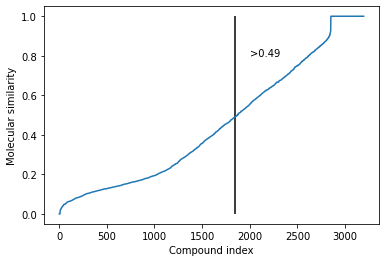

In [20]:
plt.plot(dfcomp[4], dfcomp[3])
plt.vlines(1844, 0, 1)
plt.text(2000, 0.8, '>0.49')
plt.xlabel('Compound index')
plt.ylabel('Molecular similarity')

In [22]:
with PdfPages('osra_benchmarking.pdf') as pdf:
    plt.plot(dfcomp[4], dfcomp[3])
    plt.vlines(1844, 0, 1)
    plt.text(2000, 0.8, '>0.49')
    plt.xlabel('Compound index')
    plt.ylabel('Molecular similarity')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

In [23]:
# Show similarity of true vs recovered structure 
# for various levels of molecular similarity
dfcomp[dfcomp[3]>0.6].head()

,index,0,1,2,3,4
2111,1867,594,[C@@H]1(C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(...,CC/*(=C\1/NC(=O)C(CO)NC(=O)CNC(=O)C(NC(=O)C2(N...,0.601266,2112
2112,1084,328,CCN1C(=O)c2ccccc2N2[C@]1(CCC2=O)C(=O)Nc1nc(cs1)C,CC/[C](=[C](/[C]12CCC(=O)N2c2c(C(=O)N1)cccc2)\...,0.602151,2113
2113,2987,920,Cc1cc(c2c3c1C1=C(C(=O)c3c(c(c2O)OC)O)C([C@@H](...,[Hf]=*C1OC2=C(C1(C)[Hf])C(=O)c1c3c2c([Hf])cc(c...,0.602273,2114
2114,1794,558,c12c(c(c([nH]2)/C=c\2/c(c(/c(=C/c3[nH]c(/C=c/4...,COC(=O)CCc1c2[nH]c(c1C)/C=c/1\[nH]/c(=C\c3[nH]...,0.602649,2115
2115,2294,709,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)Oc1c(=O)c2...,C=CC(=O)O[C@@H]1*[C@@]2(C*2)[C@@H](O[C@H]1C)Oc...,0.603306,2116


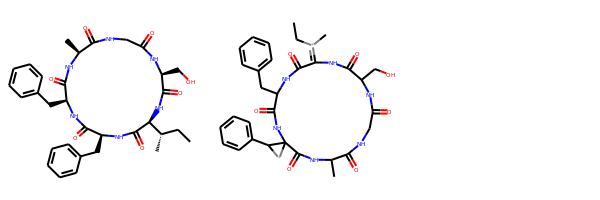

In [24]:
plot_panel(dfcomp.loc[2111, [1, 2]].tolist())

In [25]:
dfcomp[dfcomp[3]>0.7].head()

,index,0,1,2,3,4
2386,2929,904,CC(C)CC(=O)O[C@H]1[C@H]2[C@H](C[C@@H]([C@H]2CO...,OCC1C(O)CC2C1*OC=C2COC1OC(COC2OC(CO)C(C(C2O)O)...,0.700787,2387
2387,1276,408,C1(C(=C(C(=O)[C@H](C1)O)C)/C=C/C(=C/C=C/C(=C\C...,*=CC1CC(C)(C)C(=C(C1=O)C=[I])/C=C/C(=C/C=C/C(=...,0.701389,2388
2388,2947,908,c1cc(c(c(c1)Cl)CC(=O)N=C(N)N)Cl,O=C(Cc1c(Cl)cccc1Cl)N=C(*)*,0.702128,2389
2389,2156,673,CC(C)(C)C(=O)C(=S)Nc1ccccc1,S=C(C(=O)C(C)(*)*)Nc1ccccc1,0.702128,2390
2390,921,284,CC[C@H](C)[C@@H](CO)NC(=O)COc1ccc(cc1)c1cc2ccc...,CC*[C@H](NC(=O)COc1ccc(cc1)c1cc2cccc(c2oc1=O)O...,0.702970,2391


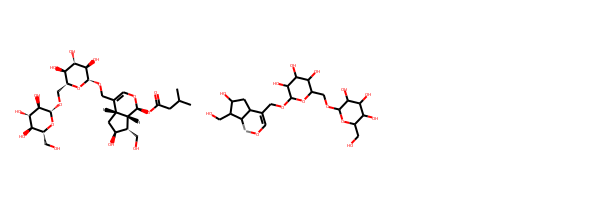

In [26]:
plot_panel(dfcomp.loc[2386, [1, 2]].tolist())

In [27]:
dfcomp[dfcomp[3]>0.8].head()

,index,0,1,2,3,4
2619,254,68,Cc1ccc(cc1)NC(=O)[C@H](CCSC)NC(=O)N1C[C@H]2C[C...,CSC*[C@@H](C(=O)Nc1ccc(cc1)C)NC(=O)N1CC2C[C@H]...,0.801980,2620
2620,523,149,c1(c(c(c(cc1OC)O)/C=C/C(=O)NC1CCCCC1)OC)C[C@@H...,*OC([C@H](Cc1c(OC)cc(c(c1OC)/C=C/C(=O)NC1CCCCC...,0.802198,2621
2621,463,124,[C@@H]1(OC(=O)C=CC1)CCCC/C=C\C/C=C\C/C=C\CCCCC,*CCCCC/C=C\C/C=C\C/C=C\CCCCC[C@@H]1CC=CC(=O)O1,0.802469,2622
2622,2055,644,c12c(cc(c(c2)[C@@H](OC(=O)C=C(C)C)C)OC)OC(=C(C...,COc1cc2OC(=C(*)*)C(=O)c2cc1[C@@H](OC(=O)C=C(C)C)C,0.802817,2623
2623,2808,865,Cn1c2ccc(=O)n(c2nn1)[C@@H]1[C@@H]([C@@H]([C@@H...,OC[C@@H]1O[C@@H]([C@@H]([C@@H]1O)C)n1c(=O)ccc2...,0.803279,2624


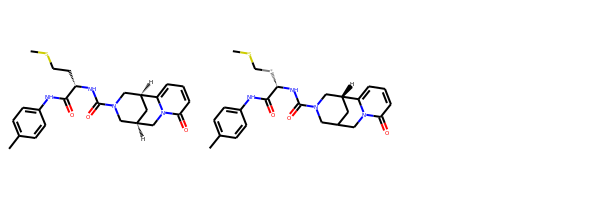

In [28]:
plot_panel(dfcomp.loc[2619, [1, 2]].tolist())

In [29]:
dfcomp[dfcomp[3]>0.9].head()

,index,0,1,2,3,4
2835,94,19,CCOC(=O)[C@H]1[C@@H](c2c(c3ccccc3oc2=O)O1)c1cc...,[Hf]COC(=O)[C@@H]1Oc2c([C@H]1c1ccccc1OCc1ccccn...,0.900990,2836
2836,484,128,[C@]12([C@@H]3[C@H]([C@@]4(O[C@H]3C[C@H]1[C@H]...,CC1CNC2(C(C1)OC(=O)[Hf])OC1C(C2C)[C@@]2(C(C1)C...,0.901961,2837
2837,1540,492,CC(C)Cn1ccc2c1cccc2NC(=O)Cn1cc(c(=O)cc1CO)OCc1...,OCc1cc(=O)c(cn1CC(=O)Nc1cccc2c1ccn2CC(C)*)OCc1...,0.901961,2838
2838,300,82,Cc1c2ccc(cc2oc(=O)c1c1ccc(c(c1)OC)OC)OC(=O)c1c...,COc1cc(ccc1OC)c1c(=O)oc2c(c1*)ccc(c2)OC(=O)c1c...,0.906977,2839
2839,2203,683,C12C(C(C(C(C1OP(=O)(OCC1OC(C(C1O)O)n1c3c(nc1)c...,CNC1C(OP(=O)(OCC2OC(C(C2O)O)n2cnc3c2ncnc3*)O)C...,0.907692,2840


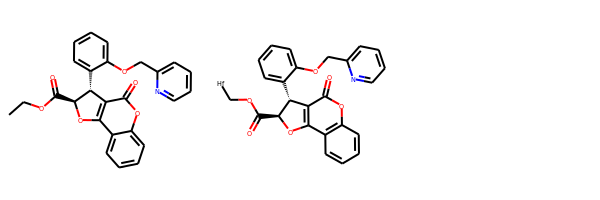

In [30]:
plot_panel(dfcomp.loc[2835, [1, 2]].tolist())

In [31]:
# Load oscar results
oscar = pd.read_csv('oscar_name.tsv', sep='\t')
oscar.head()

,name,standardInChI,standardInChIKey,doi,ExactMolWt
0,diazoaminobenzene,InChI=1S/C12H11N3/c1-3-7-11(8-4-1)13-15-14-12-...,ALIFPGGMJDWMJH-UHFFFAOYSA-N,final-302.json,197.095297
1,anisole,"InChI=1S/C7H8O/c1-8-7-5-3-2-4-6-7/h2-6H,1H3",RDOXTESZEPMUJZ-UHFFFAOYSA-N,final-302.json,108.057515
2,iodol,InChI=1S/C4H5I/c1-2-4-5-3-1/h1-5H,OMYXFRGZYJDEPI-UHFFFAOYSA-N,final-302.json,179.943598
3,"2,4-bis(chloromethyl)-3,5-dimethylbicyclo[4.2....",InChI=1S/C12H14Cl2/c1-7-9-3-4-10(9)12(6-14)8(2...,VOQZCIGSIKSGAL-UHFFFAOYSA-N,final-302.json,228.047256
4,Dioxane,InChI=1S/C4H8O2/c1-2-6-4-3-5-1/h1-4H2,RYHBNJHYFVUHQT-UHFFFAOYSA-N,final-302.json,88.052429


In [32]:
oscar.shape

(20490, 5)

In [33]:
oscar['doi'] = oscar['doi'].str.replace('\\D', '')
oscar.head()

,name,standardInChI,standardInChIKey,doi,ExactMolWt
0,diazoaminobenzene,InChI=1S/C12H11N3/c1-3-7-11(8-4-1)13-15-14-12-...,ALIFPGGMJDWMJH-UHFFFAOYSA-N,302,197.095297
1,anisole,"InChI=1S/C7H8O/c1-8-7-5-3-2-4-6-7/h2-6H,1H3",RDOXTESZEPMUJZ-UHFFFAOYSA-N,302,108.057515
2,iodol,InChI=1S/C4H5I/c1-2-4-5-3-1/h1-5H,OMYXFRGZYJDEPI-UHFFFAOYSA-N,302,179.943598
3,"2,4-bis(chloromethyl)-3,5-dimethylbicyclo[4.2....",InChI=1S/C12H14Cl2/c1-7-9-3-4-10(9)12(6-14)8(2...,VOQZCIGSIKSGAL-UHFFFAOYSA-N,302,228.047256
4,Dioxane,InChI=1S/C4H8O2/c1-2-6-4-3-5-1/h1-4H2,RYHBNJHYFVUHQT-UHFFFAOYSA-N,302,88.052429


In [34]:
# Load input reagents
reag = pd.read_csv('/home/rsilva/Documents/npmine_library/data/reagentes.tsv', 
                   sep='\t')
reag.head()

,Reagent,InChIKey
0,"1,1,1-Trichloroethane",UOCLXMDMGBRAIB-UHFFFAOYSA-N
1,"1,1,2,2-Tetrachloroethane",QPFMBZIOSGYJDE-UHFFFAOYSA-N
2,"1,2-Dichloroethane",WSLDOOZREJYCGB-UHFFFAOYSA-N
3,"1,3-Benzenediol",LUKBXSAWLPMMSZ-UHFFFAOYSA-N
4,1-Butanol,LRHPLDYGYMQRHN-UHFFFAOYSA-N


In [35]:
# Load input english dictionaries
english_dict = pd.read_csv('/home/rsilva/Documents/npmine_library/data/words_alpha.txt', header=None)
english_dict[0] = english_dict[0].str.lower()
english_dict.head()

,0
0,a
1,aa
2,aaa
3,aah
4,aahed


In [36]:
# Compare input with recovered names
nms_counts = []
recov_counts = []
submit_counts = []

reag_low = reag['Reagent'].str.lower()

for i in range(1000):
    nms = struct[i]['names']
    nms = [x.lower() for x in nms]
    nms = [re.sub('^ | $', '', x) for x in nms]
    recov = oscar.loc[oscar['doi']==str(i), 'name']
    recov_counts.append(len(recov))
    
    nrecov = recov.str.lower().isin(nms).sum()
    nms_counts.append(nrecov)
    submit_counts.append(len(nms))

In [37]:
names = pd.DataFrame([nms_counts, recov_counts, submit_counts]).T
names[3] = names[0]/names[1]
names[4] = names[0]/names[2]

names.sort_values(4, inplace=True)
names.reset_index(inplace=True)
names.head()

,index,0,1,2,3,4
0,971,0,10,1,0.0,0.0
1,431,0,11,9,0.0,0.0
2,259,0,7,6,0.0,0.0
3,858,0,29,9,0.0,0.0
4,461,0,10,11,0.0,0.0


In [38]:
# Proportion of recoved names by document
names[names[4]>0.49].head()

,index,0,1,2,3,4
267,356,10,28,20,0.357143,0.5
268,89,3,9,6,0.333333,0.5
269,446,3,12,6,0.250000,0.5
270,415,5,12,10,0.416667,0.5
271,449,8,24,16,0.333333,0.5


Text(0, 0.5, 'Proportion of recoved names')

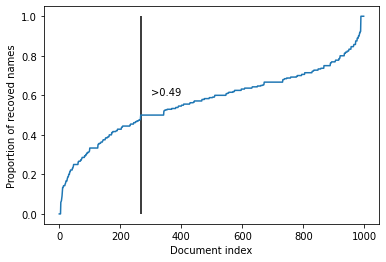

In [39]:
# NOTE: Thus the cumulative distribution functions for many common probability distributions are sigmoidal
names.sort_values(4, inplace=True)
plt.plot(range(1000), names[4])
plt.vlines(267, 0, 1)
plt.text(300, 0.6, '>0.49')
plt.xlabel('Document index')
plt.ylabel('Proportion of recoved names')

In [40]:
with PdfPages('oscar_benchmarking.pdf') as pdf:
    plt.plot(range(1000), names[4])
    plt.vlines(267, 0, 1)
    plt.text(300, 0.6, '>0.49')
    plt.xlabel('Document index')
    plt.ylabel('Proportion of recoved names')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

In [41]:
# Load gnfinder results
species = pd.read_csv('gn_dataframe.tsv', sep='\t')
species['doi'] = species['doi'].str.replace('\\D', '')
species.head()

,doi,verbatim,odds,dataSourceId,taxonId,classificationPath,classificationRank,matchType
0,925,Chryseobacterium lineare,3.609182e+11,4.0,1859201,|Bacteria|||Bacteroidetes|Flavobacteriia|Flavo...,|superkingdom|||phylum|class|order|family|genu...,ExactMatch
1,925,Cecidomyiidae,1.069498e+05,1.0,3946216,Animalia|Arthropoda|Insecta|Diptera|Cecidomyiidae,kingdom|phylum|class|order|family,ExactMatch
2,925,An-\nthomyiidae,8.695090e+04,1.0,3946232,Animalia|Arthropoda|Insecta|Diptera|Anthomyiidae,kingdom|phylum|class|order|family,ExactMatch
3,925,Banchopsis,1.274615e+05,1.0,3981772,Animalia|Arthropoda|Insecta|Hymenoptera|Ichneu...,kingdom|phylum|class|order|superfamily|family|...,ExactMatch
4,925,Symphygas nephaula,7.160308e+10,1.0,793397,Animalia|Arthropoda|Insecta|Lepidoptera|Tortri...,kingdom|phylum|class|order|superfamily|family|...,ExactCanonicalMatch


In [42]:
# Count the number of scientific names recovered
# and names recoverd until genera level
spc_counts = []
all_recov = []
all_spc = []
all_genera = []

for i in range(1000):
    spc = struct[i]['species']
    spc = [x.lower() for x in spc]
    spc = [re.sub('^ | $', '', x) for x in spc]
    recov = species.loc[species['doi']==str(i), 'verbatim']
    all_spc.append(len(spc))
    all_recov.append(len(recov))
    gen = [x.split()[0] for x in recov.str.lower()]
    all_genera.append(sum([x.split()[0] in gen for x in spc]))
    
    nrecov = recov.str.lower().isin(spc).sum()
    spc_counts.append(nrecov)

In [47]:
spdf = pd.DataFrame([spc_counts, all_genera, all_spc]).T
spdf[3] = spdf[0]/spdf[2]
spdf[4] = spdf[1]/spdf[2]

spdf.sort_values(3, inplace=True)
spdf.reset_index(inplace=True)
spdf.head()

,index,0,1,2,3,4
0,96,0,6,8,0.0,0.750000
1,448,0,6,14,0.0,0.428571
2,155,0,6,8,0.0,0.750000
3,188,0,4,16,0.0,0.250000
4,508,0,4,14,0.0,0.285714


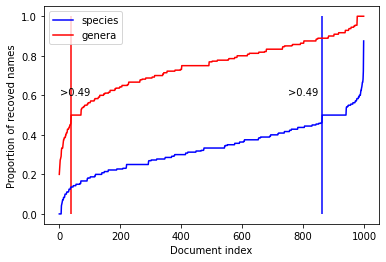

In [44]:
plt.plot(range(1000), spdf[3], color='blue', label='species')

spdf.sort_values(4, inplace=True)
plt.plot(range(1000), spdf[4], color='red', label='genera')

plt.vlines(863, 0, 1, color='blue')
plt.vlines(39, 0, 1, color='red')

plt.text(750, 0.6, '>0.49')
plt.text(3, 0.6, '>0.49')

plt.xlabel('Document index')
plt.ylabel('Proportion of recoved names')
plt.legend()

In [45]:
spdf.reset_index(drop=True, inplace=True)
spdf[spdf[4]>0.49].head()

,index,0,1,2,3,4
39,653,2,6,12,0.166667,0.5
40,507,3,8,16,0.187500,0.5
41,927,3,7,14,0.214286,0.5
42,468,8,12,24,0.333333,0.5
43,810,4,8,16,0.250000,0.5


In [48]:
with PdfPages('gnfinder_benchmarking.pdf') as pdf:
    plt.plot(range(1000), spdf[3], color='blue', label='species')

    spdf.sort_values(4, inplace=True)
    plt.plot(range(1000), spdf[4], color='red', label='genera')

    plt.vlines(863, 0, 1, color='blue')
    plt.vlines(39, 0, 1, color='red')

    plt.text(750, 0.6, '>0.49')
    plt.text(3, 0.6, '>0.49')

    plt.xlabel('Document index')
    plt.ylabel('Proportion of recoved names')
    plt.legend()
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()